I recommend to view the file at https://nbviewer.org/github/javisrv/Covid_mortality_prediction/blob/main/data_to_model.ipynb

# PREDICTING COVID-19 MORTALITY: Model Building

# [1- Loading basic libraries](#1)

# [2- Data frame loading and transforming](#2)
 
 - ## [A- Data loading and selection of columns](#2.A)
 - ## [B- OneHotEncoder()](#2.B)
 - ## [C- train_test_split()](#2.C)
 - ## [D- StandardScaler()](#2.D)
 - ## [E- Feature selection](#2.E)
     - ### [E.1- Statsmodel](#2.E.1)
     - ### [E.2- Correlation with heatmap](#2.E.2)
     - ### [E.3- VIF()](#2.E.3)
     - ### [E.4- RFE()](#2.E.4)
     
# [3- Justification of metrics](#3)

- ## [A- Data loading and selection of columns](#3.A)
- ## [B- Choosing metrics](#3.B) 

# [4- Linear Regression](#4)

# [5- Conclusion](#5)


<a id='1'></a>

---

# 1. Loading basic libraries

In [2]:
import time
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, roc_auc_score, classification_report

---

# FUNCTIONS

In [3]:
def conf_matrix(Y_train, Y_train_pred, Y_test, Y_test_pred):
    # Train Confusion Matrix 
    cf_matrix_train = confusion_matrix(Y_train, Y_train_pred)
    group_names_train = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts_train = ["{0:0.0f}".format(value) for value in cf_matrix_train.flatten()]
    labels_train = [f"{v1}\n{v2}" for v1, v2 in zip(group_names_train, group_counts_train)]
    labels_train = np.asarray(labels_train).reshape(2,2)
    
    # Test Confusion Matrix     
    cf_matrix_test = confusion_matrix(Y_test, Y_test_pred)
    group_names_test = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts_test = ["{0:0.0f}".format(value) for value in cf_matrix_test.flatten()]
    labels_test = [f"{v1}\n{v2}" for v1, v2 in zip(group_names_test, group_counts_test)]
    labels_test = np.asarray(labels_test).reshape(2,2)
    
    # Graphics
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
    sns.heatmap(cf_matrix_train, annot = labels_train, annot_kws = {'size': 14}, fmt = "", cmap = ListedColormap(["white"]), cbar = False, linewidths = 4, linecolor = 'black', ax = ax[0])
    sns.heatmap(cf_matrix_test, annot = labels_test, annot_kws = {'size': 14}, fmt = "", cmap = ListedColormap(["white"]), cbar = False, linewidths = 4, linecolor = 'black', ax = ax[1])
    
    # Titles, labels, ticks, etc
    ax[0].set_title("Train Confusion Matrix", fontsize = 20)
    ax[1].set_title("Test Confusion Matrix", fontsize = 20)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    plt.show()
    
    print("---" * 34)

In [4]:
def roc_curve_graph(Y_test, Y_test_pred_proba):
    fpr, tpr, thr = roc_curve(Y_test, Y_test_pred_proba) 

    plt.figure(figsize = (8,8))

    plt.plot(fpr, tpr, color = "black")
    plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), color = "darkgreen", linestyle = "--")

    plt.title("Test ROC Curve", fontsize = 18) 
    plt.xlabel("1 - Specificty", fontsize = 16)
    plt.ylabel("Sensitivity", fontsize = 16)

    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.yticks(ticks = [0,0.2,0.4,0.6,0.8,1], labels = ["",0.2,0.4,0.6,0.8,1], fontsize = 14)
    plt.xticks(fontsize = 14)

    style = dict(size = 14, color = "black", fontstyle = "oblique")
    props = dict(boxstyle = "round", facecolor = "grey", alpha=0.5)

    auc_score = round(auc(fpr, tpr), 2)

    plt.text(0.85, 0.1, f"AUC = {auc_score}", ha = "center", va = "bottom", **style, bbox = props)

    plt.show()
    
    print("---" * 34)

In [5]:
def metrics(Y_train, Y_test, Y_train_pred, Y_test_pred, Y_train_pred_proba, Y_test_pred_proba):
    print(f"\tTrain Precision Score:{precision_score(Y_train, Y_train_pred):.3f}")
    print(f"\tTest Precision Score:{precision_score(Y_test, Y_test_pred):.3f}")
    print("\t---" * 4)
    print(f"\tTrain Recall Score:{recall_score(Y_train, Y_train_pred):.3f}")
    print(f"\tTest Recall Score:{recall_score(Y_test, Y_test_pred):.3f}")
    print("\t---" * 4)
    print(f"\tTrain ROC AUC Score:{roc_auc_score(Y_train, Y_train_pred_proba):.3f}")
    print(f"\tTest ROC AUC Score:{roc_auc_score(Y_test, Y_test_pred_proba):.3f}")
    print("---" * 34)

In [80]:
def fit_train(model):
    print("For", str(model).split("(")[0],":")
    global fit
    fit = model.fit(X_train_std, y_train.values.reshape(-1,))
    
    y_train_pred = model.predict(X_train_std)
    y_test_pred = model.predict(X_test_std)
    
    y_train_pred_proba = model.predict_proba(X_train_std)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test_std)[:, 1]

    metrics(y_train, y_test, y_train_pred, y_test_pred, y_train_pred_proba, y_test_pred_proba)
    
    conf_matrix(y_train, y_train_pred, y_test, y_test_pred)
    roc_curve_graph(y_test, y_test_pred_proba)
    print(classification_report(y_test, y_test_pred))

<a id='2'></a>

---

# 2. Data frame loading and transforming

<a id='2.A'></a>

---

## A. Data loading and selection of columns

First the .csv file is uploaded

In [7]:
df = pd.read_csv("df_to_analize.csv", index_col = 0, encoding = "latin-1", parse_dates = ["Register_date", "Diagnosis_date", "Death_date"])
df.head()

,Register_date,Diagnosis_date,Death_date,Result_PCR,Result_RapidTest,Classification,Hospitalized,Evolution,Gender,Race,...,Comorbidity_cardiac,Comorbidity_renal,Comorbidity_diabetes,Comorbidity_smoking,Comorbidity_obesity,Delta_RegDiag,Delta_DeathReg,Age,n_comor,n_symp
0,2021-11-11,2021-11-10,NaT,Positive,NaN,Confirmed,NaN,Cured,Femenine,Brown,...,No,No,No,No,No,1,NaN,39.0,0,6
1,2021-11-10,2021-11-08,NaT,Positive,NaN,Confirmed,No,Cured,Masculine,White,...,No,No,No,No,No,2,NaN,24.0,0,4
2,2021-11-02,2021-10-29,NaT,Positive,Positive,Confirmed,No,Cured,Masculine,NaN,...,No,No,No,No,No,4,NaN,77.0,0,3
3,2021-11-09,2021-11-02,NaT,Positive,NaN,Confirmed,NaN,Cured,Femenine,Brown,...,No,No,No,No,No,7,NaN,33.0,0,5
4,2021-11-09,2021-11-09,NaT,Positive,NaN,Confirmed,NaN,Cured,Femenine,Brown,...,No,No,No,No,No,0,NaN,59.0,0,1


The file contains 384,429 rows and 30 columns.

In [8]:
df.shape

(384429, 30)

Names of the columns.

In [9]:
df.columns

Index(['Register_date', 'Diagnosis_date', 'Death_date', 'Result_PCR',
       'Result_RapidTest', 'Classification', 'Hospitalized', 'Evolution',
       'Gender', 'Race', 'Pregnant', 'Disabled', 'Fever', 'Breath_difficulty',
       'Cough', 'Rhinitis', 'Throat_pain', 'Diarrhea', 'Headache',
       'Comorbidity_pulmonary', 'Comorbidity_cardiac', 'Comorbidity_renal',
       'Comorbidity_diabetes', 'Comorbidity_smoking', 'Comorbidity_obesity',
       'Delta_RegDiag', 'Delta_DeathReg', 'Age', 'n_comor', 'n_symp'],
      dtype='object')

A problem of unbalanced classes is observed.

In [10]:
df["Evolution"].value_counts()

Cured    376739
Death      7690
Name: Evolution, dtype: int64

Columns that will not be part of the predictive models are eliminated.

In [11]:
df = df.drop(["Result_PCR", "Result_RapidTest", "Classification", "Death_date", "Register_date", "Diagnosis_date", "Delta_DeathReg"], axis = 1)

- Null values are searched.

- The nan will be replaced by `No`.

In [12]:
df.isna().sum().sort_values(ascending = False)

Hospitalized             206123
Pregnant                 178427
Race                      82187
Disabled                   4480
Comorbidity_obesity         191
Fever                        30
Comorbidity_cardiac          29
Comorbidity_pulmonary        20
Headache                     18
Breath_difficulty            16
Comorbidity_diabetes         16
Throat_pain                  15
Rhinitis                     13
Cough                        12
Diarrhea                     11
Comorbidity_smoking          10
Comorbidity_renal             7
Evolution                     0
Gender                        0
Delta_RegDiag                 0
Age                           0
n_comor                       0
n_symp                        0
dtype: int64

In [13]:
symptoms_cols = ["Fever", "Breath_difficulty", "Cough", "Rhinitis", "Throat_pain", "Diarrhea", "Headache"]
comorbidity_cols = ["Comorbidity_pulmonary", "Comorbidity_cardiac", "Comorbidity_renal", "Comorbidity_diabetes", "Comorbidity_smoking", "Comorbidity_obesity"]

In [14]:
df[symptoms_cols] = df[symptoms_cols].replace(np.nan, "No") 
df[comorbidity_cols] = df[comorbidity_cols].replace(np.nan, "No") 
df[["Hospitalized", "Pregnant", "Disabled"]] = df[["Hospitalized", "Pregnant", "Disabled"]].replace(np.nan, "No") 
df["Race"] = df["Race"].replace(np.nan, random.choice(["Brown", "White"]))

It is now observed that there are no `nan` values.

In [139]:
df.isna().sum().sort_values(ascending = False)

Hospitalized             0
Headache                 0
n_comor                  0
Age                      0
Delta_RegDiag            0
Comorbidity_obesity      0
Comorbidity_smoking      0
Comorbidity_diabetes     0
Comorbidity_renal        0
Comorbidity_cardiac      0
Comorbidity_pulmonary    0
Diarrhea                 0
Evolution                0
Throat_pain              0
Rhinitis                 0
Cough                    0
Breath_difficulty        0
Fever                    0
Disabled                 0
Pregnant                 0
Race                     0
Gender                   0
n_symp                   0
dtype: int64

Finally 384,429 rows and 23 columns remain.

In [15]:
df.shape

(384429, 23)

The Age variable is transformed into a categorical variable.

In [16]:
df["Age_cat"] = pd.cut(x = df["Age"],
       bins = [17, 24, 34, 44, 54, 64, np.inf],
       labels=['18-24', '25-34', '35-44','45-54', '55-64', '+65']).astype("str")

In [19]:
df["Age_cat"].value_counts()

35-44    96355
25-34    90916
45-54    68711
18-24    46387
55-64    46310
+65      35750
Name: Age_cat, dtype: int64

<a id='2.B'></a>

---

## B. OneHotEncoder()

Categorical variables are transformed into dummy variables.

In [23]:
categoricals = ["Hospitalized", "Evolution", "Gender", "Race", "Pregnant", "Disabled", 
                "Fever", "Breath_difficulty", "Cough", "Rhinitis", "Throat_pain", "Diarrhea", "Headache", 
                "Comorbidity_pulmonary", "Comorbidity_cardiac", "Comorbidity_renal", "Comorbidity_diabetes", "Comorbidity_smoking", "Comorbidity_obesity", "Age_cat"]

In [24]:
enc = OneHotEncoder(drop = "first")
X = df[categoricals]
enc.fit(X)
enc.categories_

[array(['No', 'Yes'], dtype=object),
 array(['Cured', 'Death'], dtype=object),
 array(['Femenine', 'Masculine'], dtype=object),
 array(['Black', 'Brown', 'Indigenous', 'White', 'Yellow'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['+65', '18-24', '25-34', '35-44', '45-54', '55-64'], dtype=object)]

In [25]:
dummies = enc.transform(X).toarray()

In [26]:
dummies[:5]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [27]:
dummies_df = pd.DataFrame(dummies)
dummies_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [28]:
col_names = [categoricals[i] + '_' + enc.categories_[i] for i in range(len(categoricals))] 
col_names

[array(['Hospitalized_No', 'Hospitalized_Yes'], dtype=object),
 array(['Evolution_Cured', 'Evolution_Death'], dtype=object),
 array(['Gender_Femenine', 'Gender_Masculine'], dtype=object),
 array(['Race_Black', 'Race_Brown', 'Race_Indigenous', 'Race_White',
        'Race_Yellow'], dtype=object),
 array(['Pregnant_No', 'Pregnant_Yes'], dtype=object),
 array(['Disabled_No', 'Disabled_Yes'], dtype=object),
 array(['Fever_No', 'Fever_Yes'], dtype=object),
 array(['Breath_difficulty_No', 'Breath_difficulty_Yes'], dtype=object),
 array(['Cough_No', 'Cough_Yes'], dtype=object),
 array(['Rhinitis_No', 'Rhinitis_Yes'], dtype=object),
 array(['Throat_pain_No', 'Throat_pain_Yes'], dtype=object),
 array(['Diarrhea_No', 'Diarrhea_Yes'], dtype=object),
 array(['Headache_No', 'Headache_Yes'], dtype=object),
 array(['Comorbidity_pulmonary_No', 'Comorbidity_pulmonary_Yes'],
       dtype=object),
 array(['Comorbidity_cardiac_No', 'Comorbidity_cardiac_Yes'], dtype=object),
 array(['Comorbidity_renal_No', 

In [29]:
col_names_drop_first = [sublist[i] for sublist in col_names for i in range(len(sublist)) if i != 0]
col_names_drop_first

['Hospitalized_Yes',
 'Evolution_Death',
 'Gender_Masculine',
 'Race_Brown',
 'Race_Indigenous',
 'Race_White',
 'Race_Yellow',
 'Pregnant_Yes',
 'Disabled_Yes',
 'Fever_Yes',
 'Breath_difficulty_Yes',
 'Cough_Yes',
 'Rhinitis_Yes',
 'Throat_pain_Yes',
 'Diarrhea_Yes',
 'Headache_Yes',
 'Comorbidity_pulmonary_Yes',
 'Comorbidity_cardiac_Yes',
 'Comorbidity_renal_Yes',
 'Comorbidity_diabetes_Yes',
 'Comorbidity_smoking_Yes',
 'Comorbidity_obesity_Yes',
 'Age_cat_18-24',
 'Age_cat_25-34',
 'Age_cat_35-44',
 'Age_cat_45-54',
 'Age_cat_55-64']

In [30]:
dummies_df.columns = col_names_drop_first
dummies_df.head()

,Hospitalized_Yes,Evolution_Death,Gender_Masculine,Race_Brown,Race_Indigenous,Race_White,Race_Yellow,Pregnant_Yes,Disabled_Yes,Fever_Yes,...,Comorbidity_cardiac_Yes,Comorbidity_renal_Yes,Comorbidity_diabetes_Yes,Comorbidity_smoking_Yes,Comorbidity_obesity_Yes,Age_cat_18-24,Age_cat_25-34,Age_cat_35-44,Age_cat_45-54,Age_cat_55-64
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [31]:
numericals = ["Delta_RegDiag", "Age", "n_comor", "n_symp"]
df_numerical = df[numericals]

In [32]:
df_final = pd.concat([dummies_df, df_numerical], axis = 1)
df_final.head(2)

,Hospitalized_Yes,Evolution_Death,Gender_Masculine,Race_Brown,Race_Indigenous,Race_White,Race_Yellow,Pregnant_Yes,Disabled_Yes,Fever_Yes,...,Comorbidity_obesity_Yes,Age_cat_18-24,Age_cat_25-34,Age_cat_35-44,Age_cat_45-54,Age_cat_55-64,Delta_RegDiag,Age,n_comor,n_symp
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1,39.0,0,6
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2,24.0,0,4


In [33]:
df_final.isna().sum()

Hospitalized_Yes             0
Evolution_Death              0
Gender_Masculine             0
Race_Brown                   0
Race_Indigenous              0
Race_White                   0
Race_Yellow                  0
Pregnant_Yes                 0
Disabled_Yes                 0
Fever_Yes                    0
Breath_difficulty_Yes        0
Cough_Yes                    0
Rhinitis_Yes                 0
Throat_pain_Yes              0
Diarrhea_Yes                 0
Headache_Yes                 0
Comorbidity_pulmonary_Yes    0
Comorbidity_cardiac_Yes      0
Comorbidity_renal_Yes        0
Comorbidity_diabetes_Yes     0
Comorbidity_smoking_Yes      0
Comorbidity_obesity_Yes      0
Age_cat_18-24                0
Age_cat_25-34                0
Age_cat_35-44                0
Age_cat_45-54                0
Age_cat_55-64                0
Delta_RegDiag                0
Age                          0
n_comor                      0
n_symp                       0
dtype: int64

In [34]:
df_final.columns

Index(['Hospitalized_Yes', 'Evolution_Death', 'Gender_Masculine', 'Race_Brown',
       'Race_Indigenous', 'Race_White', 'Race_Yellow', 'Pregnant_Yes',
       'Disabled_Yes', 'Fever_Yes', 'Breath_difficulty_Yes', 'Cough_Yes',
       'Rhinitis_Yes', 'Throat_pain_Yes', 'Diarrhea_Yes', 'Headache_Yes',
       'Comorbidity_pulmonary_Yes', 'Comorbidity_cardiac_Yes',
       'Comorbidity_renal_Yes', 'Comorbidity_diabetes_Yes',
       'Comorbidity_smoking_Yes', 'Comorbidity_obesity_Yes', 'Age_cat_18-24',
       'Age_cat_25-34', 'Age_cat_35-44', 'Age_cat_45-54', 'Age_cat_55-64',
       'Delta_RegDiag', 'Age', 'n_comor', 'n_symp'],
      dtype='object')

Rename columns.

In [35]:
df_final.columns = ["Hospitalized", "Death", "Masculine", 
                    "Race_Brown", "Race_Indigenous", "Race_White", "Race_Yellow", "Pregnant", "Disabled",
                    "Fever", "Breath_difficulty", "Cough", "Rhinitis", "Throat_pain", "Diarrhea", "Headache",
                    "Comorbidity_pulmonary", "Comorbidity_cardiac", "Comorbidity_renal", "Comorbidity_diabetes", "Comorbidity_smoking", "Comorbidity_obesity",
                    "18-24", "25-34", "35-44", "45-54", "55-64",
                    "Delta_RegDiag", "Age", "n_comor", "n_symp"]

In [36]:
df_final.head(2)

,Hospitalized,Death,Masculine,Race_Brown,Race_Indigenous,Race_White,Race_Yellow,Pregnant,Disabled,Fever,...,Comorbidity_obesity,18-24,25-34,35-44,45-54,55-64,Delta_RegDiag,Age,n_comor,n_symp
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1,39.0,0,6
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2,24.0,0,4


Column reordering.

In [37]:
df_final = df_final[["Masculine", "Age", "18-24", "25-34", "35-44", "45-54", "55-64",
                     "Race_White", "Race_Brown", "Race_Yellow", "Race_Indigenous", "Pregnant", "Disabled", 
                     "Cough", "Throat_pain", "Rhinitis", "Headache", "Fever", "Diarrhea", "Breath_difficulty", 
                     "Comorbidity_smoking", "Comorbidity_cardiac", "Comorbidity_pulmonary", "Comorbidity_diabetes", "Comorbidity_renal", "Comorbidity_obesity", 
                     "Delta_RegDiag", "n_comor", "n_symp", "Hospitalized", "Death"]]

The final dataset has 384,429 rows and 31 columns.

In [38]:
df_final.shape

(384429, 31)

<a id='2.C'></a>

---

## C. train_test_split

Training and test data are separated.

In [39]:
X = df_final.drop("Death", axis = 1)
y = df_final["Death"]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 0)

In [41]:
X_train.shape

(307543, 30)

In [42]:
X_test.shape

(76886, 30)

In [43]:
y_train.value_counts()

0.0    301391
1.0      6152
Name: Death, dtype: int64

- 98% of the data belong to the class of patients who survived.

- 2% of the data belong to the class of patients who died.

In [45]:
y_train.value_counts(normalize = True) * 100

0.0    97.999629
1.0     2.000371
Name: Death, dtype: float64

- As can be seen, we are facing a problem of unbalanced classes. 


- At the moment, no undersampling or oversampling techniques will be applied. 


- What will be done is to give weight to the classes when instantiating the models (ie: for Logistic Regression use the `class_weight` parameter).

<a id='2.D'></a>

---

## D. StandardScaler()

Data scaling is performed.

In [46]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [47]:
X_train_std = pd.DataFrame(X_train_std, columns = X_train.columns)
X_train_std.head(1)

,Masculine,Age,18-24,25-34,35-44,45-54,55-64,Race_White,Race_Brown,Race_Yellow,...,Comorbidity_smoking,Comorbidity_cardiac,Comorbidity_pulmonary,Comorbidity_diabetes,Comorbidity_renal,Comorbidity_obesity,Delta_RegDiag,n_comor,n_symp,Hospitalized
0,-0.931809,-0.536064,-0.370523,1.797628,-0.577517,-0.466958,-0.370591,-0.684295,0.898789,-0.269268,...,-0.120934,-0.404328,-0.142717,-0.231106,-0.063031,-0.150764,-0.353782,-0.438408,0.988785,-0.125048


In [48]:
X_test_std = pd.DataFrame(X_test_std, columns = X_test.columns)
X_test_std.head(1)

,Masculine,Age,18-24,25-34,35-44,45-54,55-64,Race_White,Race_Brown,Race_Yellow,...,Comorbidity_smoking,Comorbidity_cardiac,Comorbidity_pulmonary,Comorbidity_diabetes,Comorbidity_renal,Comorbidity_obesity,Delta_RegDiag,n_comor,n_symp,Hospitalized
0,1.073182,-0.337782,-0.370523,-0.556289,1.731552,-0.466958,-0.370591,-0.684295,0.898789,-0.269268,...,-0.120934,-0.404328,-0.142717,-0.231106,-0.063031,-0.150764,1.195679,-0.438408,-0.281003,-0.125048


<a id='2.E'></a>

---

## E. Feature selection

<a id='2.E.1'></a>

### E.1 Statsmodel

Statistical estimators of `p` will be used to select the first features, as a first approach.

In [49]:
X_train_sm = X_train_std.copy()

In [50]:
X_train_stats = sm.add_constant(X_train_sm)

In [51]:
logit = sm.Logit(y_train.values.reshape(-1, ), X_train_stats)
result = logit.fit()
print(result.summary2())

         Current function value: 0.055601
         Iterations: 35


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                  Results: Logit
Model:                     Logit                 Pseudo R-squared:      0.433     
Dependent Variable:        y                     AIC:                   34261.2259
Date:                      2022-08-22 13:38      BIC:                   34590.9534
No. Observations:          307543                Log-Likelihood:        -17100.   
Df Model:                  30                    LL-Null:               -30156.   
Df Residuals:              307512                LLR p-value:           0.0000    
Converged:                 0.0000                Scale:                 1.0000    
No. Iterations:            35.0000                                                
----------------------------------------------------------------------------------
                       Coef.   Std.Err.      z     P>|z|     [0.025       0.975]  
----------------------------------------------------------------------------------
const                 -5.5210     0.03

- Features related to symptoms are eliminated, since, for example, whether or not a patient has a fever should not predict death.
- `Breath_difficulty` is taken as an exception.

In [52]:
X_train_sm = X_train_sm.drop(["Cough", "Throat_pain", "Rhinitis", "Headache", "Fever", "Diarrhea"], axis = 1)

A new test is performed.

In [53]:
X_train_stats = sm.add_constant(X_train_sm)

In [54]:
logit = sm.Logit(y_train.values.reshape(-1, ), X_train_stats)
result = logit.fit()
print(result.summary2())

         Current function value: 0.056242
         Iterations: 35


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                 Results: Logit
Model:                   Logit                 Pseudo R-squared:      0.426     
Dependent Variable:      y                     AIC:                   34643.4255
Date:                    2022-08-22 13:39      BIC:                   34909.3348
No. Observations:        307543                Log-Likelihood:        -17297.   
Df Model:                24                    LL-Null:               -30156.   
Df Residuals:            307518                LLR p-value:           0.0000    
Converged:               0.0000                Scale:                 1.0000    
No. Iterations:          35.0000                                                
--------------------------------------------------------------------------------
                       Coef.   Std.Err.      z     P>|z|     [0.025     0.975]  
--------------------------------------------------------------------------------
const                 -5.4601     0.0363 -150.5931 0.0000    

Age categories are eliminated as they do not have statistical significance.

In [55]:
X_train_sm = X_train_sm.drop(["18-24", "25-34", "35-44", "45-54", "55-64"], axis = 1)

A new test is performed.

In [56]:
X_train_stats = sm.add_constant(X_train_sm)

In [57]:
logit = sm.Logit(y_train.values.reshape(-1, ), X_train_stats)
result = logit.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.056248
         Iterations 10
                                 Results: Logit
Model:                   Logit                 Pseudo R-squared:      0.426     
Dependent Variable:      y                     AIC:                   34637.5909
Date:                    2022-08-22 13:39      BIC:                   34850.3183
No. Observations:        307543                Log-Likelihood:        -17299.   
Df Model:                19                    LL-Null:               -30156.   
Df Residuals:            307523                LLR p-value:           0.0000    
Converged:               1.0000                Scale:                 1.0000    
No. Iterations:          10.0000                                                
--------------------------------------------------------------------------------
                       Coef.   Std.Err.      z     P>|z|     [0.025     0.975]  
---------------------------------------

- The category of race is eliminated because it does not have statistical significance.
- `Race_White` has statistical significance.

In [58]:
X_train_sm = X_train_sm.drop(["Race_Brown", "Race_Yellow", "Race_Indigenous"], axis = 1)

In [59]:
X_train_stats = sm.add_constant(X_train_sm)

In [60]:
logit = sm.Logit(y_train.values.reshape(-1, ), X_train_stats)
result = logit.fit()
print(result.summary2())

         Current function value: 0.056257
         Iterations: 35


C:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                  Results: Logit
Model:                    Logit                  Pseudo R-squared:       0.426     
Dependent Variable:       y                      AIC:                    34636.6927
Date:                     2022-08-22 13:39       BIC:                    34817.5110
No. Observations:         307543                 Log-Likelihood:         -17301.   
Df Model:                 16                     LL-Null:                -30156.   
Df Residuals:             307526                 LLR p-value:            0.0000    
Converged:                0.0000                 Scale:                  1.0000    
No. Iterations:           35.0000                                                  
-----------------------------------------------------------------------------------
                       Coef.    Std.Err.      z     P>|z|     [0.025       0.975]  
-----------------------------------------------------------------------------------
const                 -5.43

- Some features have a value of `p = nan`. Some extra analysis will be done for clarity.

- `n_comor`, `Delta_RegDiag`: This variables are described in the literature as factors that could predict mortality, therefore they are not eliminated at the moment.

<a id='2.E.2'></a>

### E.2 Correlation with heatmap

Collinearity is sought between numerical variables.

In [61]:
X_train_std.columns

Index(['Masculine', 'Age', '18-24', '25-34', '35-44', '45-54', '55-64',
       'Race_White', 'Race_Brown', 'Race_Yellow', 'Race_Indigenous',
       'Pregnant', 'Disabled', 'Cough', 'Throat_pain', 'Rhinitis', 'Headache',
       'Fever', 'Diarrhea', 'Breath_difficulty', 'Comorbidity_smoking',
       'Comorbidity_cardiac', 'Comorbidity_pulmonary', 'Comorbidity_diabetes',
       'Comorbidity_renal', 'Comorbidity_obesity', 'Delta_RegDiag', 'n_comor',
       'n_symp', 'Hospitalized'],
      dtype='object')

In [62]:
categoricals = ["Masculine", "18-24", "25-34", "35-44", "45-54", "55-64",
                "Race_White", "Race_Brown", "Race_Yellow", "Race_Indigenous", 
                "Pregnant", "Disabled", 
                "Cough", "Throat_pain", "Rhinitis", "Headache", "Fever", "Diarrhea", "Breath_difficulty", 
                "Comorbidity_smoking", "Comorbidity_cardiac", "Comorbidity_pulmonary", "Comorbidity_diabetes", "Comorbidity_renal", "Comorbidity_obesity",
                "Hospitalized"]
numericals = ["Age", "Delta_RegDiag", "n_comor", "n_symp"]

In [63]:
corr = pd.concat([X_train[numericals], y_train], axis = 1).corr(method = "pearson")

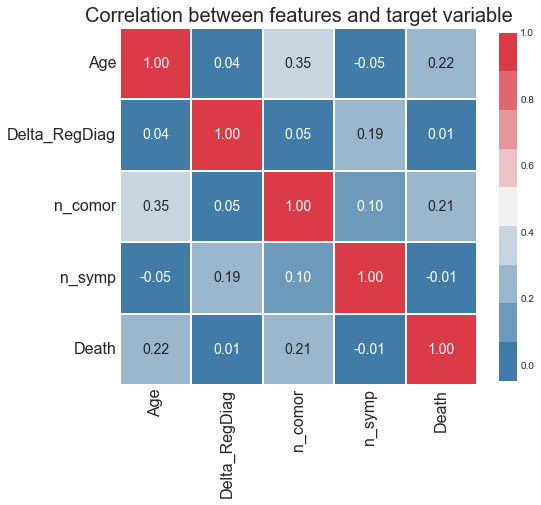

In [64]:
plt.style.use("seaborn-white")

fig, ax = plt.subplots(figsize = (8, 8))

cmap = sns.diverging_palette(240, 10, n = 9, center = 'light')

sns.heatmap(corr, linewidths =.2, cmap = cmap, cbar_kws = {"shrink": .8}, square = True, xticklabels = True, yticklabels = True, annot = True, annot_kws = {'size': 14}, fmt = '.2f');

plt.title("Correlation between features and target variable", fontsize = 20)
plt.yticks(fontsize =  16, rotation = 0) 
plt.xticks(fontsize = 16, rotation = 90)

plt.show()

- A strong correlation (pearson > 0.80) between the numerical variables is not observed.

- It is observed that `Age` and `n_comor` are correlated with the target variable.

<a id='2.E.3'></a>

### E.3 VIF

In [65]:
def compute_vif(considered_features):
    
    X = X_train[considered_features]
    # the calculation of variance inflation requires a constant
    X["intercept"] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif["Variable"] != "intercept"]
    return vif

In [66]:
compute_vif(numericals).sort_values(by = "VIF", ascending = False) 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_4776\3266933239.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["intercept"] = 1


,Variable,VIF
2,n_comor,1.163129
0,Age,1.155376
3,n_symp,1.057500
1,Delta_RegDiag,1.040887


<a id='2.E.4'></a>

### E.4 RFE()

- Recursive Feature Elmination (RFE) starts to iterate with all the features, builds a model and discards the least important feature encoding to the model. 

- Then a new model is built using all but the discarded feature, and so on until only a prespecificied number of features are left. 

Columns that do not have statistical significance according to statsmodel are eliminated (except for `comorbidities`, `n_comor` and `Delta_RegDiag`)

In [67]:
X_train_std = X_train_std.drop(["Cough", "Throat_pain", "Rhinitis", "Headache", "Fever", "Diarrhea",
                               "18-24", "25-34", "35-44", "45-54", "55-64",
                               "Race_Brown", "Race_Yellow", "Race_Indigenous"], axis = 1)

Randomforest + RFE will be used to keep 10 features.

In [68]:
select = RFE(RandomForestClassifier(n_estimators = 100, random_state = 123), n_features_to_select = 10)
select.fit(X_train_std, y_train.values.reshape(-1,))

RFE(estimator=RandomForestClassifier(random_state=123), n_features_to_select=10)

The columns that remain after applying RFE are observed.

In [69]:
cols = select.get_support(indices = True)
X_train_std = X_train_std.iloc[:, cols]
X_train_std.head(2)

,Masculine,Age,Race_White,Breath_difficulty,Comorbidity_cardiac,Comorbidity_diabetes,Delta_RegDiag,n_comor,n_symp,Hospitalized
0,-0.931809,-0.536064,-0.684295,-0.379458,-0.404328,-0.231106,-0.353782,-0.438408,0.988785,-0.125048
1,-0.931809,-0.536064,-0.684295,-0.379458,-0.404328,-0.231106,0.679192,-0.438408,-0.281003,-0.125048


In [70]:
X_test_std = X_test_std[X_train_std.columns]

In [71]:
print("X_train_std.shape:", X_train_std.shape)
print("y_train.shape:", y_train.shape)
print("---" * 16)
print("X_test_std.shape:", X_test_std.shape)
print("y_test.shape:", y_test.shape)


X_train_std.shape: (307543, 10)
y_train.shape: (307543,)
------------------------------------------------
X_test_std.shape: (76886, 10)
y_test.shape: (76886,)


In [72]:
X_test_std.head()

,Masculine,Age,Race_White,Breath_difficulty,Comorbidity_cardiac,Comorbidity_diabetes,Delta_RegDiag,n_comor,n_symp,Hospitalized
0,1.073182,-0.337782,-0.684295,-0.379458,-0.404328,-0.231106,1.195679,-0.438408,-0.281003,-0.125048
1,1.073182,-0.469970,1.461359,-0.379458,2.473239,-0.231106,0.162705,1.302898,0.353891,-0.125048
2,-0.931809,-0.271688,-0.684295,-0.379458,-0.404328,-0.231106,-1.903242,-0.438408,-1.550791,-0.125048
3,-0.931809,0.653631,-0.684295,-0.379458,-0.404328,-0.231106,1.195679,-0.438408,-0.915897,-0.125048
4,-0.931809,0.851913,-0.684295,-0.379458,-0.404328,-0.231106,-1.903242,-0.438408,0.988785,-0.125048


The training and test sets are saved in .csv files.

In [73]:
X_train_std.to_csv("X_train_std.csv", index = False)
y_train.to_csv("y_train.csv", index = False)
X_test_std.to_csv("X_test_std.csv", index = False)
y_test.to_csv("y_test.csv", index = False)

<a id='3'></a>

---

# 3. Justification of metrics

<a id='3.A'></a>

## A. Understanding the context of the problem

- The models that will be constructed below will be thought in the context of a patient attended in an outpatient ward. In this situation, the physician must decide which patients should be referred to a common hospital ward and which patients should be referred to the intensive care unit (ICU).


- If the patient is very likely to die then he will NOT be referred to the ICU, in order not to occupy a bed in this unit.


- When choosing a metric to evaluate the performance of a predictive model, it is important to ask: What could be the consequences of making a classification error in the real world?

    - In this sense, a `true positive (TP)` would be equivalent to stating: "This patient is going to die, he should NOT be referred to the ICU." What happens is that the patient dies and the objective of not occupying an extra ICU bed is achieved. This in turn allows the initiation of end-of-life care for the patient, which includes the presence of the family, in order to say goodbye to the patient. 
    - A `false positive (FP)` would be equivalent to stating: "This patient is going to die, he should NOT be referred to the ICU." But what happens is that the patient does NOT die and has a chance of survival by being referred to the ICU. The problem is that if the patient is not constantly monitored (a situation that occurs while hospitalized in the ICU), there is an increased risk of death.
    - A `true negative (TN)` would be equivalent to stating, "This patient is NOT going to die, he should be referred to the ICU." In this case the patient does NOT die and an extra ICU bed is occupied. 
    - A `false negative (FN)` would be equivalent to stating, "This patient is NOT going to die, he should be referred to the ICU." In this case the patient dies and an extra ICU bed is occupied. 
    
- Based on the paragraph above in the models `it will weigh more to have less PF than FN`, because it is more important to avoid an increased probability of death of a patient by not being referred in time to the ICU (less FP) than to occupy an extra bed (less FN). 

<a id='3.B'></a>

## B. Choosing metrics

- Accuracy: Since there are unbalanced classes, accuracy is not a good evaluation metric. So it will not be taken into account. 

- Precision: 
    - Measures how many of the samples predicted as positive are actually positive. → Precision = TP / (TP + FP)
    - Precision is used as a performance metric when the goal is to limit the number of `false positives`.
    - Remember: 
        - A `false positive (FP)` would be equivalent to stating: "This patient is going to die, he should NOT be referred to the ICU." 
        - But what happens is that the patient does NOT die and has a chance of survival by being referred to the ICU. 
        - The problem is that if the patient is not constantly monitored (a situation that occurs while hospitalized in the ICU), there is an increased risk of death.
        
- Recall:
    - Measures how many of the positive samples are captured by the positive predictions. → Recall = TP / (TP + FN)
    - Recall is used as performance metric when we need to identify all positive samples, that is, when it is important to avoid false negatives.
    - Remember: 
        - A `false negative (FN)` would be equivalent to stating, "This patient is NOT going to die, he should be referred to the ICU." 
        - But what happens is that the patient dies.
        - In this case an extra ICU bed is occupied.
        
- ROC and AUC:
    - The ROC curve considers all possible thresholds for a given classifier, it shows the False Positive Rate (FPR) against the Ture Positive Rate (TPR)
    - FPR = FP / (FP + TN). (Remember that in the models we will look for the least amount of PF possible) 
    - TPR = Recall = TP / (TP + FN).
    - Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between patients who will die and will not die.

The training and testing files are loaded.

In [74]:
X_train_std = pd.read_csv("X_train_std.csv")
y_train = pd.read_csv("y_train.csv")
X_test_std = pd.read_csv("X_test_std.csv")
y_test = pd.read_csv("y_test.csv")

In [76]:
print("X_train_std.shape:", X_train_std.shape)
print("y_train.shape:", y_train.shape)
print("---" * 16)
print("X_test_std.shape:", X_test_std.shape)
print("y_test.shape:", y_test.shape)

X_train_std.shape: (307543, 10)
y_train.shape: (307543, 1)
------------------------------------------------
X_test_std.shape: (76886, 10)
y_test.shape: (76886, 1)


<a id='4'></a>

---

# 4. Linear Regression

A logistic regression is applied without setting hyperparameters.

In [77]:
lr = LogisticRegression(max_iter = 3000)

For LogisticRegression :
	Train Precision Score:0.653
	Test Precision Score:0.635
	---	---	---	---
	Train Recall Score:0.307
	Test Recall Score:0.306
	---	---	---	---
	Train ROC AUC Score:0.939
	Test ROC AUC Score:0.936
------------------------------------------------------------------------------------------------------


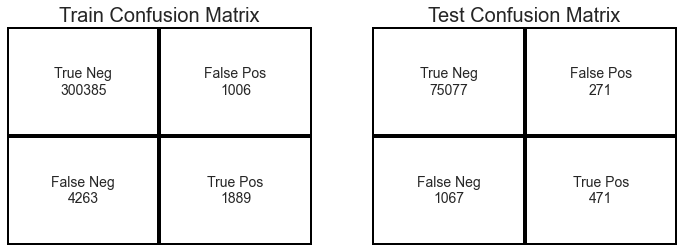

------------------------------------------------------------------------------------------------------


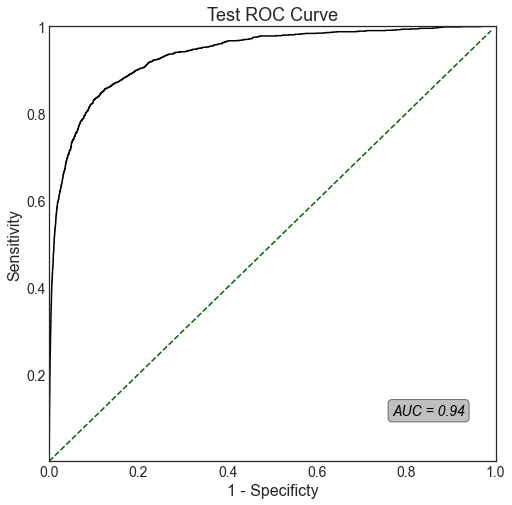

------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     75348
         1.0       0.63      0.31      0.41      1538

    accuracy                           0.98     76886
   macro avg       0.81      0.65      0.70     76886
weighted avg       0.98      0.98      0.98     76886



In [81]:
fit_train(lr)

- Adequate values are observed for `Precision` (which is what is sought).

- This is at the cost of a low `Recall` value.

- On the other hand, the `AUC` is high, so it has a high discriminatory capacity.

- No overfitting is observed in the three metrics.

- In the `confusion matrix`, `FP` are given more importance than `FN`.

The hyperparameter `class_weight` is set to `balanced`.

In [82]:
lr_weight = LogisticRegression(max_iter = 3000, class_weight = 'balanced')

For LogisticRegression :
	Train Precision Score:0.129
	Test Precision Score:0.129
	---	---	---	---
	Train Recall Score:0.851
	Test Recall Score:0.850
	---	---	---	---
	Train ROC AUC Score:0.939
	Test ROC AUC Score:0.936
------------------------------------------------------------------------------------------------------


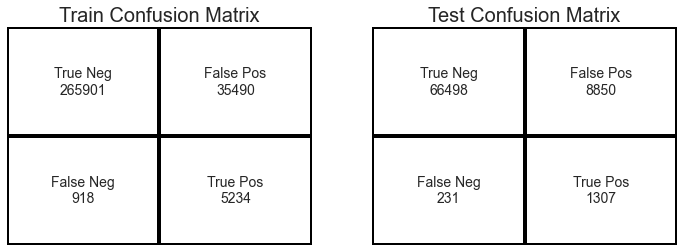

------------------------------------------------------------------------------------------------------


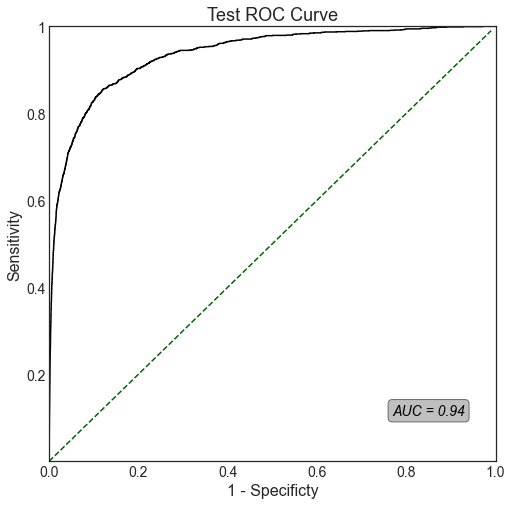

------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94     75348
         1.0       0.13      0.85      0.22      1538

    accuracy                           0.88     76886
   macro avg       0.56      0.87      0.58     76886
weighted avg       0.98      0.88      0.92     76886



In [83]:
fit_train(lr_weight)

- While there is a large increase in `Recall` value, it is at the expense of a very low `Precision` value.

- Therefore, it will be tried to give weight to the classes `manually`.

In [84]:
lr = LogisticRegression()

#Setting the range for class weights
weights = np.linspace(0.0, 0.99, 100)

#Creating a dictionary grid for grid search
param_grid = {"class_weight": [{0: x, 1: 1.0 - x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch_weights = GridSearchCV(estimator =  lr, 
                          param_grid = param_grid,
                          cv = StratifiedKFold(), 
                          n_jobs = -1, 
                          scoring = "precision", 
                          verbose = 2)
gridsearch_weights.fit(X_train_std, y_train.values.reshape(-1,))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.0, 1: 1.0}, {0: 0.01, 1: 0.99},
                                          {0: 0.02, 1: 0.98},
                                          {0: 0.03, 1: 0.97},
                                          {0: 0.04, 1: 0.96},
                                          {0: 0.05, 1: 0.95},
                                          {0: 0.06, 1: 0.94},
                                          {0: 0.07, 1: 0.9299999999999999},
                                          {0: 0.08, 1: 0.92},
                                          {0: 0.09, 1: 0.91}, {0: 0.1, 1: 0.9},
                                          {0: 0.11, 1: 0.89},
                                          {0: 0.12, 1: 0.88},
                                          {0: 0.13, 1: 0.87},
                                          {0: 0.14, 1: 0.86},
                                          {0: 0.15, 1: 0.85},
                                          {0: 0.16, 1: 0.84},
                                          {0: 0.17, 1: 0.83},
                                          {0: 0.18, 1: 0.8200000000000001},
                                          {0: 0.19, 1: 0.81}, {0: 0.2, 1: 0.8},
                                          {0: 0.21, 1: 0.79},
                                          {0: 0.22, 1: 0.78},
                                          {0: 0.23, 1: 0.77},
                                          {0: 0.24, 1: 0.76},
                                          {0: 0.25, 1: 0.75},
                                          {0: 0.26, 1: 0.74},
                                          {0: 0.27, 1: 0.73},
                                          {0: 0.28, 1: 0.72},
                                          {0: 0.29, 1: 0.71}, ...]},
             scoring='precision', verbose=2)

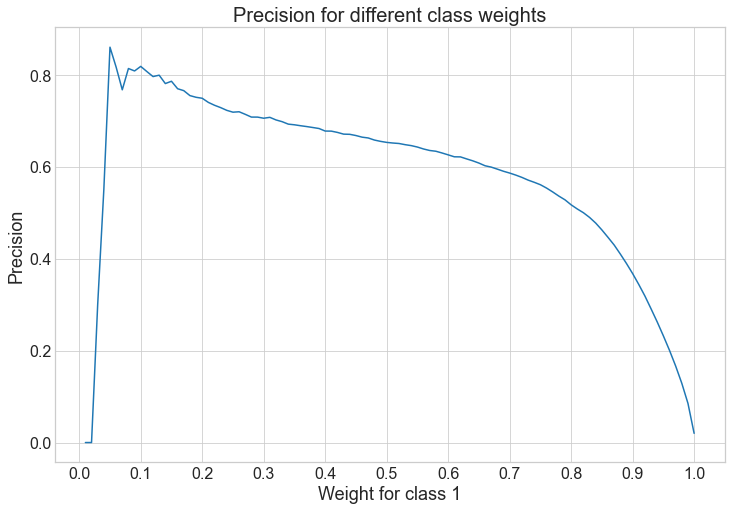

In [85]:
#Ploting the score for different values of weight
sns.set_style("whitegrid")

plt.figure(figsize = (12,8))

weigh_data = pd.DataFrame({"Score": gridsearch_weights.cv_results_["mean_test_score"], "Weight": (1- weights)})
sns.lineplot(x = "Weight", y = "Score", data = weigh_data)

plt.title("Precision for different class weights", fontsize = 20)
plt.xlabel("Weight for class 1", fontsize = 18)
plt.ylabel("Precision", fontsize = 18)
plt.xticks([round(i/10,1) for i in range(0,11,1)], fontsize = 16)
plt.yticks(fontsize = 16)

plt.show()

- It is observed that the highest `Precision` value is obtained when the weight of `class 1 = 0.05`.

- Set the hyperparameter `class_weight = {0: 0.95, 1: 0.05}`.

In [86]:
lr_weight_manual_95_5 = LogisticRegression(max_iter = 3000, class_weight = {0: 0.95, 1: 0.05})

For LogisticRegression :
	Train Precision Score:0.846
	Test Precision Score:1.000
	---	---	---	---
	Train Recall Score:0.002
	Test Recall Score:0.001
	---	---	---	---
	Train ROC AUC Score:0.938
	Test ROC AUC Score:0.935
------------------------------------------------------------------------------------------------------


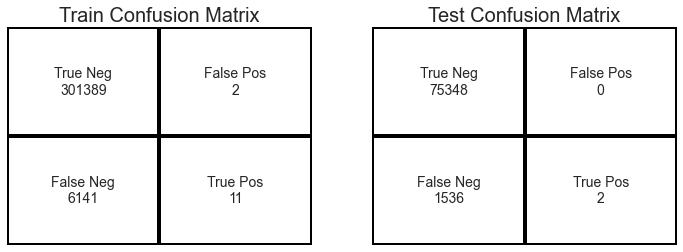

------------------------------------------------------------------------------------------------------


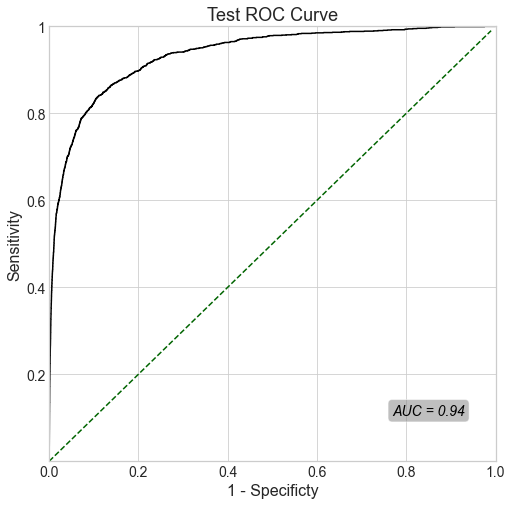

------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     75348
         1.0       1.00      0.00      0.00      1538

    accuracy                           0.98     76886
   macro avg       0.99      0.50      0.50     76886
weighted avg       0.98      0.98      0.97     76886



In [87]:
fit_train(lr_weight_manual_95_5)

Having such extremely low Recall values, a slightly more optimal balance will be sought with respect to the weight of the classes.

In [88]:
lr_weight_manual_70_30 = LogisticRegression(max_iter = 3000, class_weight = {0: 0.70, 1: 0.30})

For LogisticRegression :
	Train Precision Score:0.707
	Test Precision Score:0.709
	---	---	---	---
	Train Recall Score:0.191
	Test Recall Score:0.195
	---	---	---	---
	Train ROC AUC Score:0.938
	Test ROC AUC Score:0.935
------------------------------------------------------------------------------------------------------


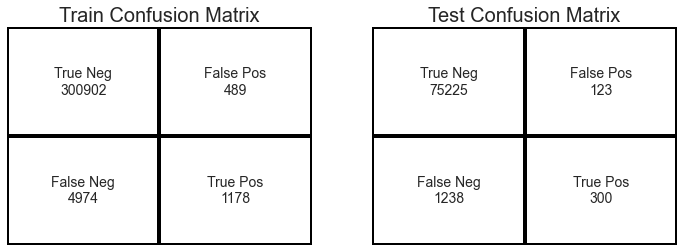

------------------------------------------------------------------------------------------------------


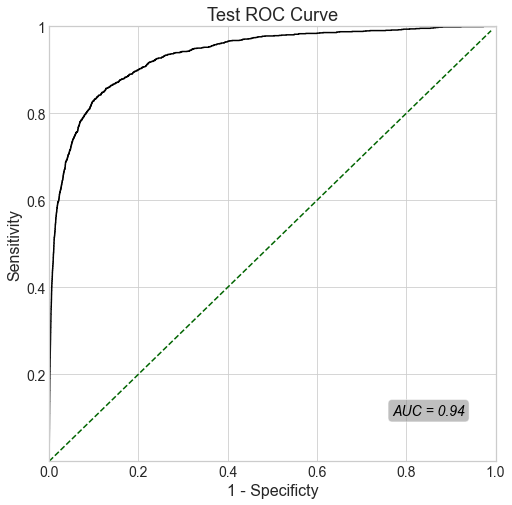

------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     75348
         1.0       0.71      0.20      0.31      1538

    accuracy                           0.98     76886
   macro avg       0.85      0.60      0.65     76886
weighted avg       0.98      0.98      0.98     76886



In [89]:
fit_train(lr_weight_manual_70_30)

- In this case, a bit of overfitting is observed since the metrics perform a little better in the test set.

- With `Precision` value of 0.71 we have a `low FP ratio`, at the expense of `increasing the FN` (as seen in the `confusion matrix`).

- It will seek to reduce overfitting through regularization.

Next we will see how the `Precision` metric behaves for the training set when the `thresholds are modified`.

In [90]:
lr = LogisticRegression(max_iter = 3000)

	Threshold = 0.1
	Train Precision Score:0.562
	Train Recall Score:0.451
	---	---	---	---
	Threshold = 0.2
	Train Precision Score:0.634
	Train Recall Score:0.352
	---	---	---	---
	Threshold = 0.3
	Train Precision Score:0.664
	Train Recall Score:0.289
	---	---	---	---
	Threshold = 0.4
	Train Precision Score:0.688
	Train Recall Score:0.240
	---	---	---	---
	Threshold = 0.5
	Train Precision Score:0.707
	Train Recall Score:0.191
	---	---	---	---
	Threshold = 0.7
	Train Precision Score:0.753
	Train Recall Score:0.096
	---	---	---	---
	Threshold = 0.8
	Train Precision Score:0.795
	Train Recall Score:0.044
	---	---	---	---
	Threshold = 0.9
	Train Precision Score:0.782
	Train Recall Score:0.007
	---	---	---	---


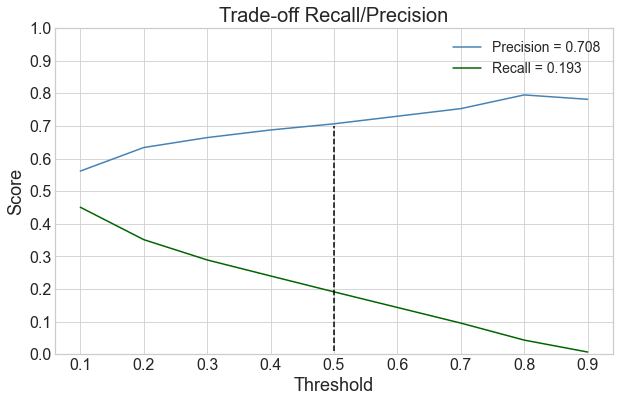

In [91]:
threshold_lr = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9]
plot_precision = []
plot_recall = []
for i in threshold_lr:
    lr_weight_manual_70_30.fit(X_train_std, y_train.values.reshape(-1, ))
    y_train_pred_lr = lr_weight_manual_70_30.predict_proba(X_train_std)[:, 1] > i
    plot_precision.append(precision_score(y_train, y_train_pred_lr))
    plot_recall.append(recall_score(y_train, y_train_pred_lr))
    print(f"\tThreshold = {i}")
    print(f"\tTrain Precision Score:{precision_score(y_train, y_train_pred_lr):.3f}")
    print(f"\tTrain Recall Score:{recall_score(y_train, y_train_pred_lr):.3f}")
    print("\t---" * 4)

fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(threshold_lr, plot_precision, label = "Precision = 0.708", color = "steelblue")
plt.plot(threshold_lr, plot_recall, label = "Recall = 0.193", color = "darkgreen")

plt.title("Trade-off Recall/Precision", fontsize = 20)
plt.xlabel("Threshold", fontsize = 18)
plt.ylabel("Score", fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(np.arange(0,1.1,0.1), fontsize = 16)
plt.ylim(0,1)

plt.vlines(0.5, ymin = 0.01, ymax = 0.70, linestyles = '--', color = "black")

plt.legend(fontsize = 14)

plt.show()

It is decided to use the default `threshold = 0.5`.

In [92]:
threshold_lr = 0.5

y_train_pred_cf = lr_weight_manual_70_30.predict_proba(X_train_std)[:, 1] > threshold_lr
y_test_pred_cf = lr_weight_manual_70_30.predict_proba(X_test_std)[:, 1] > threshold_lr

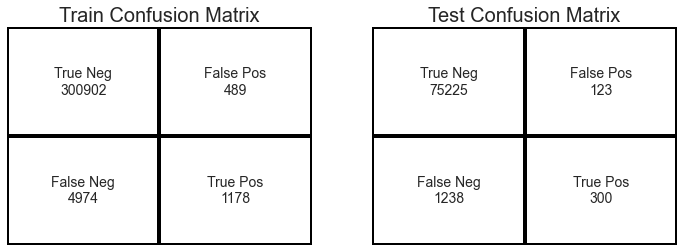

------------------------------------------------------------------------------------------------------
	Train Precision Score:0.707
	Test Precision Score:0.709
	---	---	---	---
	Train Recall Score:0.191
	Test Recall Score:0.195


In [93]:
conf_matrix(y_train, y_train_pred_cf, y_test, y_test_pred_cf)
print(f"\tTrain Precision Score:{precision_score(y_train, y_train_pred_cf):.3f}")
print(f"\tTest Precision Score:{precision_score(y_test, y_test_pred_cf):.3f}")
print("\t---" * 4)
print(f"\tTrain Recall Score:{recall_score(y_train, y_train_pred_cf):.3f}")
print(f"\tTest Recall Score:{recall_score(y_test, y_test_pred_cf):.3f}")

The coefficients that determine the model are shown below.

In [95]:
fit_lr = fit
weights_lr = fit_lr.coef_
df_weights_lr = pd.DataFrame(weights_lr, columns = X_train_std.columns).T
df_weights_lr = df_weights_lr.rename(columns = {0: "Coefficient"}).sort_values(by = "Coefficient", ascending = False)
df_weights_lr

,Coefficient
Age,1.162256
Breath_difficulty,0.383564
Hospitalized,0.379737
n_comor,0.343841
Masculine,0.195347
Delta_RegDiag,-0.004742
Comorbidity_diabetes,-0.026910
Race_White,-0.045942
n_symp,-0.120767
Comorbidity_cardiac,-0.142503


`GridSearchCV + Regularization` is then used, in search of the `C` hyperparameter that best performs the `Precision` metric.

In [96]:
C = [0.001, 0.01, 0.1, 1, 10, 100]

for i in C:    
    lr_weight_manual_reg = LogisticRegression(C = i, penalty = "l1", solver = "liblinear", max_iter = 3000, class_weight = {0: 0.70, 1: 0.3})
    lr_weight_manual_reg.fit(X_train_std, y_train.values.reshape(-1, ))
    y_train_pred = lr_weight_manual_reg.predict(X_train_std)
    y_test_pred = lr_weight_manual_reg.predict(X_test_std)
    print(f"C = {i}")
    print('Train precision_score: ', precision_score(y_train, y_train_pred).round(2))
    print('Test precision_score: ', precision_score(y_test, y_test_pred).round(2))
    print("--- ---" * 4)     
    print('Train recall_score: ', recall_score(y_train, y_train_pred).round(2))
    print('Test recall_score: ', recall_score(y_test, y_test_pred).round(2))
    print("---"*24)

C = 0.001
Train precision_score:  0.82
Test precision_score:  0.79
--- ------ ------ ------ ---
Train recall_score:  0.01
Test recall_score:  0.01
------------------------------------------------------------------------
C = 0.01
Train precision_score:  0.71
Test precision_score:  0.71
--- ------ ------ ------ ---
Train recall_score:  0.18
Test recall_score:  0.19
------------------------------------------------------------------------
C = 0.1
Train precision_score:  0.71
Test precision_score:  0.71
--- ------ ------ ------ ---
Train recall_score:  0.19
Test recall_score:  0.2
------------------------------------------------------------------------
C = 1
Train precision_score:  0.71
Test precision_score:  0.71
--- ------ ------ ------ ---
Train recall_score:  0.19
Test recall_score:  0.2
------------------------------------------------------------------------
C = 10
Train precision_score:  0.71
Test precision_score:  0.71
--- ------ ------ ------ ---
Train recall_score:  0.19
Test recal

C = 0.01 will be used

In [97]:
lr_weight_manual_70_30_001 = LogisticRegression(C = 0.01, penalty = "l1", solver = "liblinear", max_iter = 3000, class_weight = {0: 0.70, 1: 0.3})

For LogisticRegression :
	Train Precision Score:0.710
	Test Precision Score:0.714
	---	---	---	---
	Train Recall Score:0.182
	Test Recall Score:0.187
	---	---	---	---
	Train ROC AUC Score:0.938
	Test ROC AUC Score:0.936
------------------------------------------------------------------------------------------------------


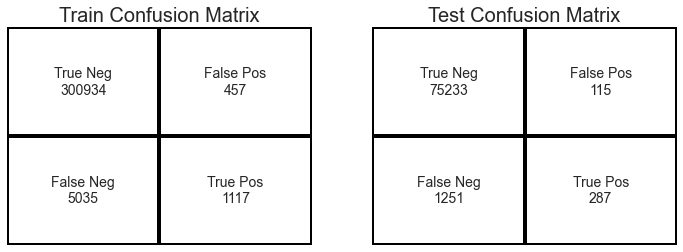

------------------------------------------------------------------------------------------------------


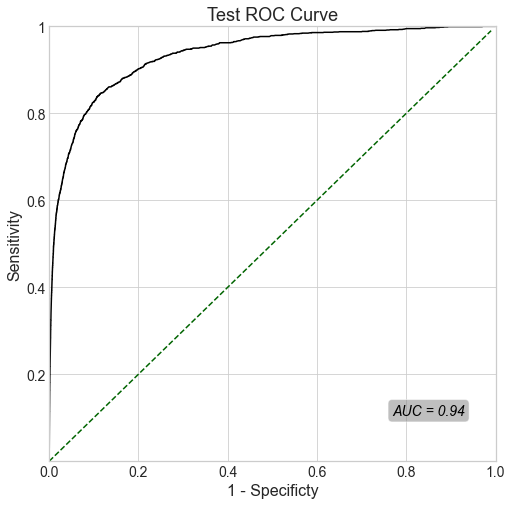

------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     75348
         1.0       0.71      0.19      0.30      1538

    accuracy                           0.98     76886
   macro avg       0.85      0.59      0.64     76886
weighted avg       0.98      0.98      0.98     76886



In [98]:
fit_train(lr_weight_manual_70_30_001)

- Despite using `low values of C` to make the model simpler, a bit of `overfitting` is still observed.

- Extremely low values reduce `Recall` too much.

- The value of `C` is reduced a little, to `0.007`.

In [99]:
lr_weight_manual_70_30_007 = LogisticRegression(C = 0.007, penalty = "l1", solver = "liblinear", max_iter = 3000, class_weight = {0: 0.70, 1: 0.3})

- The coefficients that define the model are observed.

- In this case the `most important features` are:
    - Age
    - Hospitalized
    - Breath_difficulty
    - n_comor
    - Masculine

In [101]:
fit_lr = lr_weight_manual_70_30_007.fit(X_train_std, y_train.values.reshape(-1,))
weights_lr = fit_lr.coef_
df_weights_lr = pd.DataFrame(weights_lr, columns = X_train_std.columns).T
df_weights_lr = df_weights_lr.rename(columns = {0: "Coefficient"}).sort_values(by = "Coefficient", ascending = False)
df_weights_lr

,Coefficient
Age,0.942579
Hospitalized,0.383849
Breath_difficulty,0.288178
n_comor,0.196110
Masculine,0.087189
Race_White,0.000000
Comorbidity_cardiac,0.000000
Comorbidity_diabetes,0.000000
Delta_RegDiag,0.000000
n_symp,0.000000


We run the Logistic Regression only with the variables that determine the model, making it simpler, to see if the small amount of overfitting can be reduced.

In [111]:
train_final = X_train_std[["Age", "Hospitalized", "Breath_difficulty", "n_comor", "Masculine"]]
test_final = X_test_std[["Age", "Hospitalized", "Breath_difficulty", "n_comor", "Masculine"]]

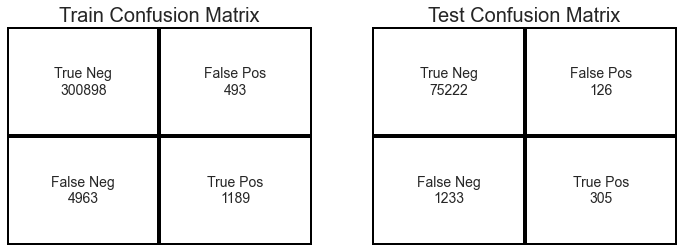

------------------------------------------------------------------------------------------------------
	Train Precision Score:0.707
	Test Precision Score:0.708
	---	---	---	---
	Train Recall Score:0.193
	Test Recall Score:0.198


In [112]:
lr_weight_manual_70_30.fit(train_final, y_train.values.reshape(-1,))

y_train_pred_final = lr_weight_manual_70_30.predict(train_final)
y_test_pred_final = lr_weight_manual_70_30.predict(test_final)

conf_matrix(y_train, y_train_pred_final, y_test, y_test_pred_final)
print(f"\tTrain Precision Score:{precision_score(y_train, y_train_pred_final):.3f}")
print(f"\tTest Precision Score:{precision_score(y_test, y_test_pred_final):.3f}")
print("\t---" * 4)
print(f"\tTrain Recall Score:{recall_score(y_train, y_train_pred_final):.3f}")
print(f"\tTest Recall Score:{recall_score(y_test, y_test_pred_final):.3f}")

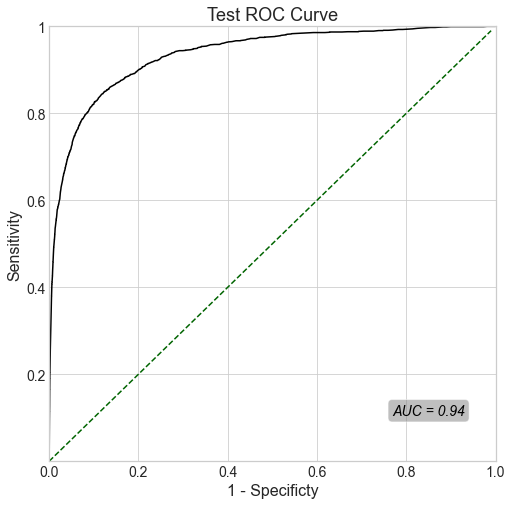

------------------------------------------------------------------------------------------------------


In [114]:
roc_curve_graph(y_test, lr_weight_manual_70_30.predict_proba(test_final)[:, 1])

In [115]:
  print(classification_report(y_test, y_test_pred_final))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     75348
         1.0       0.71      0.20      0.31      1538

    accuracy                           0.98     76886
   macro avg       0.85      0.60      0.65     76886
weighted avg       0.98      0.98      0.98     76886



<a id='5'></a>

---

# 5. Conclusion

- For the final Logistic Regression model, the following hyperparameters were used:
    - C = 0.007
    - penalty = "l1"
    - max_iter = 3000
    - class_weight = {0: 0.70, 1: 0.3} 
    
- The threshold was set at 0.5 (same value as the default).

Through the logistic regression model, the following metrics were found:
    
    - Precision:
        - Train = 0.707
        - Test = 0.708
    - Recall:
        - Train = 0.193
        - Test = 0.198
    - AUC = 0.94
    - Número de FP:
        - Train = 493
        - Test = 126
    - Número de FN:
        - Train = 4963
        - Test = 1233

- Therefore, it is interpreted that the following model can correctly discern those patients who are really going to die, without generating high PF values.

- This allows the clinician to provide comfort care to the patient, avoiding therapeutic stubbornness, even allowing the patient's family presence during their last moments of life.

- However, the cost is a high number of FN that could generate an overload in the intensive care units.